# ***Question 1 - Biggest predictor of a large CO<sub>2</sub> output***

At first I'm importing the required packages so I can write my code clearly

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import duckdb as ddb

In [2]:
pd.set_option(
    'display.max_columns', None,
    'display.max_rows', 1000,
    'display.float_format', lambda x: '%.3f' % x
    )

Here I'm getting the needed data from a raw data source, with checking if the data loads like it should.

I've chosen this data source because these are relations that are commonly announced in media and other information sources.

In [3]:
# import data
df_co2 = pd.read_csv("https://ourworldindata.org/grapher/co2-emissions-per-capita.csv?v=1&csvType=full&useColumnShortNames=false") 
df_gdp = pd.read_csv("https://ourworldindata.org/grapher/gdp-per-capita-worldbank.csv?v=1&csvType=full&useColumnShortNames=false")
df_ff = pd.read_csv("https://ourworldindata.org/grapher/fossil-fuel-cons-per-capita.csv?v=1&csvType=full&useColumnShortNames=false")

# df_co2.head()
# df_gdp.head()
# df_ff.head()


In this tab I will change the names of the columns, to improve the workflow.

In [4]:
# Rename column in df_gdp & df_ff
df_co2.rename(columns={'Annual CO₂ emissions (per capita)': "CO2"}, inplace=True)
df_gdp.rename(columns={'GDP per capita, PPP (constant 2021 international $)': "GDP"}, inplace=True)
df_ff.rename(columns={'Coal per capita (kWh)': "Coal"}, inplace=True)
df_ff.rename(columns={'Oil per capita (kWh)': "Oil"}, inplace=True)
df_ff.rename(columns={'Gas per capita (kWh)': "Gas"}, inplace=True)


Next I will drop a column that is not required for my analysis.

Now I can work with data that has no redundant information.

In [5]:
# Drop World regions according to OWID column in gdp dataframe
df_gdp.drop(columns= ['World regions according to OWID'], inplace=True)

Here I'm merging the different dataframes on the most important data (CO<sub>2</sub>), and drop duplicated column names, I do this to work with one dataframe, wich is needed for correlation and regression purposes.

Also I do a left join because I only need the data on gdp and fossil fuels where there is data on CO<sub>2</sub>.

In [6]:
# merge co2 & gdp dataframe
df_merged = pd.merge(df_co2, df_gdp.drop(columns=['Entity']), how='left', on=['Code', 'Year'])


In [7]:
# Merge gpd & fossil fuel dataframe
df_merged = pd.merge(df_merged, df_ff.drop(columns=['Entity']) ,how='left', on=['Code', 'Year'])


It can be that the influence of each separate fossil fuel source will be less than the combined sources because not every country uses every source.

That's why I've made a combined fuel source column to also be able to see the combined effect on CO<sub>2</sub>

In [8]:
# Create total fossil fuel column
df_merged['Total ff'] = df_merged['Coal'] + df_merged['Oil'] + df_merged['Gas']


In [9]:
df_merged['Total ff MWh'] = df_merged['Total ff'] / 1000  # convert kWh to MWh

I noticed some missing values so I checked if there was any data on "andorra" in the fossil fuel data frame,

There was no data so I'm going to drop data later on.

In [10]:
ddb.query("""
    select *
    from df_ff
    where entity ilike '%andorra%'""")

┌─────────┬─────────┬───────┬────────┬────────┬────────┐
│ Entity  │  Code   │ Year  │  Coal  │  Oil   │  Gas   │
│ varchar │ varchar │ int64 │ double │ double │ double │
├─────────┴─────────┴───────┴────────┴────────┴────────┤
│                        0 rows                        │
└──────────────────────────────────────────────────────┘

In [11]:
# Create total fossil fuel column
df_merged['Total ff'] = df_merged['Coal'] + df_merged['Oil'] + df_merged['Gas']

# Copy dataset & Drop rows with missing values
df_final = df_merged.copy()
df_final.dropna(inplace=True)
df_final#.head()

,Entity,Code,Year,CO2,GDP,Coal,Oil,Gas,Total ff,Total ff MWh
4923,Algeria,DZA,1990,2.991,11728.546,302.027,4406.227,7688.374,12396.628,12.397
4924,Algeria,DZA,1991,3.000,11314.864,304.310,4256.890,7414.690,11975.890,11.976
4925,Algeria,DZA,1992,2.977,11241.415,352.893,4179.445,7471.252,12003.590,12.004
4926,Algeria,DZA,1993,2.981,10743.706,280.549,4060.370,6545.568,10886.487,10.886
4927,Algeria,DZA,1994,3.150,10414.035,258.562,3802.842,6747.477,10808.881,10.809
...,...,...,...,...,...,...,...,...,...,...
98872,World,OWID_WRL,2020,4.458,18698.060,5365.325,6225.591,4907.321,16498.237,16.498
98873,World,OWID_WRL,2021,4.635,19751.975,5612.226,6517.965,5057.011,17187.202,17.187
98874,World,OWID_WRL,2022,4.678,20281.531,5600.878,6677.395,4994.093,17272.367,17.272
98875,World,OWID_WRL,2023,4.708,20785.270,5600.664,6777.123,4962.004,17339.791,17.340


I started with filtering out the non country specific data (World), because World is not a country.

Next I noticed an outlier in plotting so I checked the given data (Kuwait 1991), I've decided to remove this because it was caused by a one time event during the gulf war. 

In [12]:
def clean_data(df_final):
    # Filter rows based on column: 'Entity', 'index'
    df_final = df_final[df_final['Entity'] != "World"]
    df_final = df_final.sort_values('CO2', ascending=False).iloc[1:]
    return df_final

df_final_clean = clean_data(df_final.copy())

In [13]:
df_final_clean

,Entity,Code,Year,CO2,GDP,Coal,Oil,Gas,Total ff,Total ff MWh
83219,Qatar,QAT,1997,76.715,87140.125,0.000,40205.140,188474.420,228679.560,228.680
83223,Qatar,QAT,2001,67.727,92115.830,0.000,36742.793,154467.520,191210.313,191.210
83218,Qatar,QAT,1996,65.162,69746.220,0.000,34251.810,183430.440,217682.250,217.682
83216,Qatar,QAT,1994,64.819,69119.950,0.000,33921.305,279747.060,313668.365,313.668
83217,Qatar,QAT,1995,64.491,68732.530,0.000,31930.566,271661.970,303592.536,303.593
...,...,...,...,...,...,...,...,...,...,...
15962,Bangladesh,BGD,1994,0.146,2279.094,2.850,223.169,506.765,732.784,0.733
15961,Bangladesh,BGD,1993,0.136,2234.810,3.100,218.138,486.764,708.002,0.708
15960,Bangladesh,BGD,1992,0.133,2174.382,8.472,198.394,443.029,649.895,0.650
15959,Bangladesh,BGD,1991,0.130,2101.383,9.195,181.241,413.997,604.433,0.604


Here I'm checking what the correlation is between CO<sub>2</sub> and each of the independent variables.

With this outcome I'm creating a graph of the highest correlation.

In [14]:
# Calculate correlation between CO2 and GDP, all fossil fuels and total fossil fuel usage

corr_from_df_gdp = df_final[['GDP', 'CO2']].corr(numeric_only=True)
corr_from_df_Total = df_final[['Total ff', 'CO2']].corr(numeric_only=True)
corr_from_df_Coal = df_final[['Coal', 'CO2']].corr(numeric_only=True)
corr_from_df_Oil = df_final[['Oil', 'CO2']].corr(numeric_only=True)
corr_from_df_Gas = df_final[['Gas', 'CO2']].corr(numeric_only=True)

print('\n')
print("correlation with corr = ", corr_from_df_gdp)
print('\n')
print("correlation with corr = ", corr_from_df_Total)
print('\n')
print("correlation with corr = ", corr_from_df_Coal)
print('\n')
print("correlation with corr = ", corr_from_df_Oil)
print('\n')
print("correlation with corr = ", corr_from_df_Gas)




correlation with corr =        GDP   CO2
GDP 1.000 0.454
CO2 0.454 1.000


correlation with corr =            Total ff   CO2
Total ff     1.000 0.688
CO2          0.688 1.000


correlation with corr =        Coal   CO2
Coal 1.000 0.150
CO2  0.150 1.000


correlation with corr =        Oil   CO2
Oil 1.000 0.446
CO2 0.446 1.000


correlation with corr =        Gas   CO2
Gas 1.000 0.629
CO2 0.629 1.000


Correlation is a relationship between two variables, if a correlation is stronger it will be either closer to 1 or -1, if there is no correlation it will be 0

As you can see above, the correlation of 'Total ff' is the highest so this is the biggest predictor of CO<sub>2</sub>.

Since the correlation between total fossil fuels and CO<sub>2</sub> is the highest I will choose this one for a regression, to better understand the relationship.

I've adjusted the KWh to MWh because the scale wasn't clear to read when plotting the function

In [15]:
# Calculate correlation between CO2 and total fossil fuel usage

corr_from_df_Total_MWh = df_final[['Total ff MWh', 'CO2']].corr(numeric_only=True)

print("correlation with corr = ", corr_from_df_Total_MWh)


correlation with corr =                Total ff MWh   CO2
Total ff MWh         1.000 0.688
CO2                  0.688 1.000


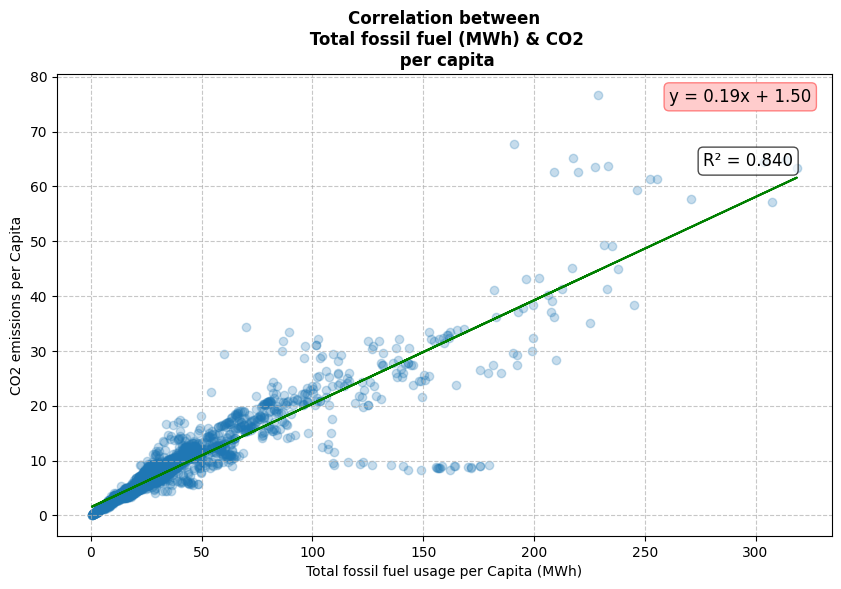

In [16]:
# Visualize the correlation for Total

plt.figure(figsize=(10, 6))
x = df_final_clean['Total ff MWh'].values
y = df_final_clean['CO2'].values

# R-squared for simple linear regression is the square of Pearson's r
r_squared = np.corrcoef(x, y)[0, 1] ** 2
plt.annotate(f"R\u00b2 = {r_squared:.3f}", xy=(0.95, 0.80), xycoords='axes fraction',
             ha='right', fontsize=12, bbox=dict(boxstyle="round", fc="white", alpha=0.7))

slope, intercept = np.polyfit(df_final_clean['Total ff MWh'],df_final_clean['CO2'], 1)
plt.plot(df_final_clean['Total ff MWh'], slope * df_final_clean['Total ff MWh'] + intercept, color='green')

plt.scatter(y=df_final_clean['CO2'],x=df_final_clean['Total ff MWh'], alpha=0.25)

# Add the equation to the plot
equation = f"y = {slope:.2f}x + {intercept:.2f}"
plt.text(0.79, 0.95, equation, transform=plt.gca().transAxes, fontsize=12, va='center', bbox=dict(boxstyle="round", ec=(1., 0.5, 0.5), fc=(1., 0.8, 0.8)))

plt.xlabel('Total fossil fuel usage per Capita (MWh)')
plt.ylabel('CO2 emissions per Capita')
plt.title('Correlation between\n Total fossil fuel (MWh) & CO2\n per capita', fontweight = 'bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

I have added a R<sup>2</sup> to indicate the strength of the predictive value, derived from the model.
With a value of approximately 0.84 it indicates a strong predictive relationship between total fossil fuel usage and CO2 emissions per capita.

# Conclusion

- As shown in the written code I've checked multiple CO<sub>2</sub> sources, I assessed the correlation between each of the possible predictors and CO<sub>2</sub> output.
- The highest correlation was between Total Fossil Fuels, so from the correlation perspective this seems to be the biggest predictor.